In [1]:
from pandasql import sqldf 
import pandas as pd
import datetime
import seaborn as sns
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
pd.set_option('display.max_columns', None)

In [2]:
team = pd.read_excel('Interview Project Data.xlsx', sheet_name='Team Data')
game = pd.read_excel('Interview Project Data.xlsx', sheet_name='Game Data')
seat = pd.read_excel('Interview Project Data.xlsx', sheet_name='Seating Chart') 
price = pd.read_excel('Interview Project Data.xlsx', sheet_name='Ticket Price Data') 
scan = pd.read_excel('Interview Project Data.xlsx', sheet_name='Ticket Scan Data')

In [3]:
#central is 2 hours ahead of pacific time. So convert scan_datetime to PST for uniform data.
offset=timedelta(hours=2)

In [4]:
scan.dtypes

scan_unique_id            object
event_name                object
event_datetime    datetime64[ns]
section_name               int64
row_name                  object
seat_number                int64
scan_gate                 object
scan_location             object
scan_datetime     datetime64[ns]
dtype: object

In [5]:
scan['scan_datetime_pst']=scan['scan_datetime']-offset

### Do weekend games (Friday, Saturday, Sunday), on average, have a higher attendance than weekday games (Monday through Thursday)?

In [6]:
sqldf("SELECT count(*)/3 as weekend \
      from scan \
      where strftime('%w',event_datetime) not in ('1','2','3','4'); \
      ")

,weekend
0,53878


In [7]:
sqldf("SELECT count(*)/4 as weekday \
      from scan \
      where strftime('%w',event_datetime)  in ('1','2','3','4');")

,weekday
0,45959


On average, weekend games have a higher attendance compared to weekday games. 53878 compared to 45959

### Identify and rank the top 4 opponents with the highest average number of attendances.

In [8]:
game['Date']=pd.to_datetime(game['Date'])

In [9]:
sqldf("select t.Opponent,t.count /q.count as Attendance from \
      (select Opponent,count(*) as count from game \
        group by Opponent) as q, \
      (select g.Opponent, count(distinct scan_unique_id) as count from \
      scan s inner join game g on substr(s.event_datetime,1,10) = substr(g.Date,1,10) \
      group by g.Opponent \
      ) as t \
      where q.Opponent=t.Opponent \
      order by Attendance desc \
      limit 4")


,Opponent,Attendance
0,Houston Rockets,5406
1,Utah Jazz,5287
2,Boston Celtics,5050
3,Los Angeles Lakers,4738


The top 4 opponents with the highest average number of attendances are Ranked as above.

### Identify and rank the top 10 sections that are, on average, the most filled to their capacity.

In [10]:
df=scan.groupby(['section_name'])['section_name'].count().reset_index(
  name='Count').sort_values(['Count'], ascending=False).head(10)
df.set_index('section_name',inplace=True)

In [11]:
df1=pd.DataFrame(seat.groupby('section_name')['seat_count'].sum().sort_values(ascending=False)*41)
df1.head()

,seat_count
section_name,
116,21812
106,21771
107,21033
115,20992
108,19352


In [12]:
df2=pd.merge(df,df1,on='section_name')
#df2.set_index('section_name',inplace=True)

In [13]:
df2['Ratio']=df2['Count']/df2['seat_count']
df2.sort_values('Ratio',ascending=False).head(10)

,Count,seat_count,Ratio
section_name,,,
106,17117,21771,0.786229
116,16861,21812,0.773015
105,7961,10414,0.764452
115,15760,20992,0.750762
107,15478,21033,0.735891
301,11060,15252,0.725151
117,11075,16277,0.680408
304,7744,11562,0.669780
108,12911,19352,0.667166


### Is there a correlation between the opponent team having a higher Vegas Odds Score (indicating higher probability of winning a championship) and higher attendance?

In [14]:
test=sqldf("select t.Opponent,t.count /q.count as Attendance from \
      (select Opponent,count(*) as count from game \
        group by Opponent) as q, \
      (select g.Opponent, count(distinct scan_unique_id) as count from \
      scan s inner join game g on substr(s.event_datetime,1,10) = substr(g.Date,1,10) \
      group by g.Opponent \
      ) as t \
      where q.Opponent=t.Opponent \
      order by Attendance desc \
        ")
pd.DataFrame(test)

,Opponent,Attendance
0,Houston Rockets,5406
1,Utah Jazz,5287
2,Boston Celtics,5050
3,Los Angeles Lakers,4738
4,New York Knicks,4716
5,Sacramento Kings,4680
6,San Antonio Spurs,4662
7,Milwaukee Bucks,4579
8,Dallas Mavericks,4516
9,Philadelphia 76ers,4452


In [15]:
df3=pd.merge(test,team, left_on='Opponent',right_on='Team Full Name')

In [16]:
df3.rename(columns={'Vegas Odds for 1819': 'Odds'}, inplace=True)

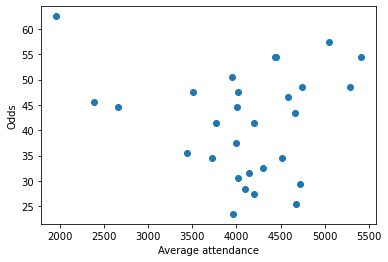

In [17]:
plt.scatter(df3['Attendance'],df3['Odds'])
plt.xlabel("Average attendance")
plt.ylabel("Odds")
plt.show()

In [18]:
result = sm.ols('Odds~Attendance', data=df3).fit()

In [19]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   Odds   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                    0.1566
Date:                Thu, 06 Jan 2022   Prob (F-statistic):              0.695
Time:                        09:51:39   Log-Likelihood:                -108.61
No. Observations:                  29   AIC:                             221.2
Df Residuals:                      27   BIC:                             224.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     45.7244     10.770      4.246      0.0

There does not seem to be a correlation between the attendance and Vegas Odds

### On average, which 15-minute period before or after the start of a game has the highest number of people scanning. (Example 30 – 16 minutes prior to the start of a game)

In [20]:
df=scan.copy()

In [21]:
df['scan_datetime_pst_diff']=(df['scan_datetime_pst']-df['event_datetime']).astype('timedelta64[m]')

In [22]:
# Find the earliest and latest a person scanned before/after the start of the game.

In [23]:
print(df['scan_datetime_pst_diff'].min(),df['scan_datetime_pst_diff'].max())

-246.0 169.0


In [24]:
max_count=0
max_interval=999

In [25]:
for time in range(-255,180,15):
    count=df[(df['scan_datetime_pst_diff'] >= time) & (df['scan_datetime_pst_diff'] < time+15)].shape[0]
    if count>max_count:
        max_count=count
        max_interval=time

In [26]:
max_interval

-15

On average, the 15 - 0 minutes prior to start of a game has the highest number of people scannning.

# Develop a model to predict the at regular season games attendance.

### EDA

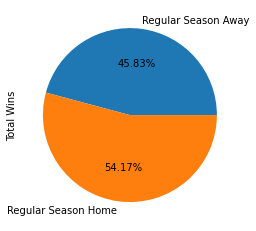

In [27]:
regular=game[game['Game Type'].str.contains('Regular')]
win=regular.where(regular['Result']=='W').groupby('Game Type')['Total Wins'].count()
win.plot.pie(subplots=True,autopct='%.2f%%')
plt.show()

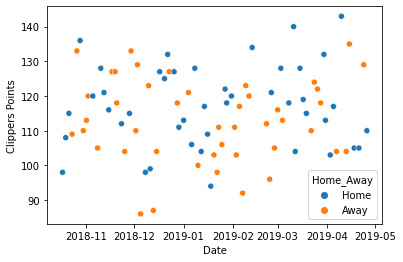

In [28]:
game['Home_Away']=game['Game Type'].map(lambda x: 'Home' if x in ['Regular Season Home','Playoffs Home'] else 'Away' )
sns.scatterplot(x='Date', y='Clippers Points', data=game, hue='Home_Away')
plt.show()

In [29]:
game=game.drop('Home_Away',axis=1)

### Feature Engineering

Basic Feature engineering done below
home_game table has all home games alone. df1 is a temporary dataframe used to join to home_game

In [30]:
scan['Date']=scan['event_datetime'].dt.date
df1=scan.groupby(['Date']).Date.agg('count').to_frame('Attendance').reset_index()
df1['Date']=pd.to_datetime(df1['Date'])
df1.set_index('Date',inplace=True)
game['dayofweek']=game['Date'].dt.day_name()

In [31]:
game['Weekend_Binary']=game['dayofweek'].map(lambda x: 0 if x in ['Monday','Tuesday','Wednesday','Thursday'] else 1)
game['Game_Type_Binary']=game['Game Type'].map(lambda x: 0 if x in ['Regular Season Home','Regular Season Away'] else 1 )
home_game=game.copy()
home_game['dayofweek']=game['Date'].dt.day_name()
home_game=home_game[~home_game['Game Type'].isin(['Regular Season Away','Playoffs Away'])]

In [32]:
home_game=pd.merge(home_game,df1, on='Date')

In [33]:
# No attendance record available for away games, no attendance record available for Home playoff games either

In [34]:
home_game=pd.merge(home_game,team[['Team Full Name','Vegas Odds for 1819']],left_on='Opponent', right_on='Team Full Name', how='left')

In [35]:
home_game.drop('Team Full Name',axis=1,inplace=True)

Let's first look at the distribution of Attendance. We can see that the countplot peaks at around 8500.

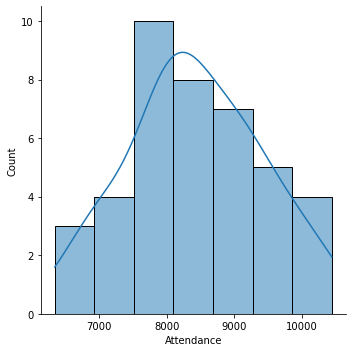

In [36]:
sns.displot(data=home_game,x='Attendance',kde=True)
plt.show()

function to encode losing/winning streak with numbers below.

In [37]:
def streak(x):
    if x =='L 1':
        y=-1
    elif x=='L 2':
        y=-2
    elif x=='L 3':
        y=-3
    elif x=='L 4':
        y=-4
    elif x=='L 5':
        y=-5
    elif x=='W 1':
        y=1
    elif x=='W 2':
        y=2
    elif x=='W 3':
        y=3
    elif x=='W 4':
        y=4
    elif x=='W 5':
        y=5
    return y

In [38]:
home_game['Overtime_Binary']=home_game['Overtime'].map(lambda x: 0 if x in ['No'] else 1 )
home_game['Result_Binary']=home_game['Result'].map(lambda x: 0 if x in ['L'] else 1 )

### Linear Regression Analysis

In [39]:
data=home_game.copy()
data['Streak_Numeric']=data['Streak'].map(streak)
data=data.drop('Streak',axis=1)

In [40]:
data=pd.get_dummies(data)

In [41]:
data=data.drop(['Game Type_Regular Season Home','Result_L','Result_W','Overtime_No','Overtime_Yes','dayofweek_Friday','dayofweek_Monday','dayofweek_Saturday','dayofweek_Sunday', 'dayofweek_Thursday',
       'dayofweek_Tuesday', 'dayofweek_Wednesday'],axis=1)

In [43]:
# 29 teams have 29 dummy variables so I have dropped the last one
df3=data.copy()
df3=df3.drop('Opponent_Washington Wizards',axis=1)

In [44]:
df3.rename(columns={'Vegas Odds for 1819': 'Odds','Clippers Points':'Clippers_Points','Opponent Points':'Opponent_Points',
                    'Total Wins':'Total_Wins','Total Losses':'Total_Losses',
                    }, inplace=True)

Adding '_' between each word in the team variable else the sm.ols will throw error. Below is code for correcting that issue

In [45]:
cols=df3.columns[18:]

In [46]:
s='_'
for col in cols:
    x=str.split(col, ' ')
    y=s.join(x)
    df3=df3.rename(columns={col:y})

In [47]:
result = sm.ols('Attendance~ Clippers_Points+Opponent_Points+\
       Total_Wins+Total_Losses+ Weekend_Binary+\
       Odds+ Overtime_Binary+ Result_Binary+\
       +Streak_Numeric + Opponent_Atlanta_Hawks+ Opponent_Boston_Celtics+\
       Opponent_Brooklyn_Nets+ Opponent_Charlotte_Hornets+\
       Opponent_Chicago_Bulls+ Opponent_Cleveland_Cavaliers+\
       Opponent_Dallas_Mavericks+ Opponent_Denver_Nuggets+\
       Opponent_Detroit_Pistons+ Opponent_Golden_State_Warriors+\
       Opponent_Houston_Rockets+ Opponent_Indiana_Pacers+\
       Opponent_Los_Angeles_Lakers+ Opponent_Memphis_Grizzlies+\
       Opponent_Miami_Heat+ Opponent_Milwaukee_Bucks+\
       Opponent_Minnesota_Timberwolves+ Opponent_New_Orleans_Pelicans+\
       Opponent_New_York_Knicks+ Opponent_Oklahoma_City_Thunder+\
       Opponent_Orlando_Magic+ Opponent_Philadelphia_76ers+\
       Opponent_Phoenix_Suns+ Opponent_Portland_Trail_Blazers+\
       Opponent_Sacramento_Kings+ Opponent_San_Antonio_Spurs+\
       Opponent_Toronto_Raptors+ Opponent_Utah_Jazz', data=df3).fit()

In [48]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             Attendance   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.001
Date:                Thu, 06 Jan 2022   Prob (F-statistic):              0.579
Time:                        09:51:39   Log-Likelihood:                -293.10
No. Observations:                  41   AIC:                             660.2
Df Residuals:                       4   BIC:                             723.6
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [49]:
result1 = sm.ols('Attendance~ Clippers_Points+Opponent_Points+\
       Total_Wins+Total_Losses+ Weekend_Binary+\
       Odds+ Overtime_Binary+ Result_Binary+\
       +Streak_Numeric', data=df3).fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:             Attendance   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     1.623
Date:                Thu, 06 Jan 2022   Prob (F-statistic):              0.152
Time:                        09:51:39   Log-Likelihood:                -332.40
No. Observations:                  41   AIC:                             684.8
Df Residuals:                      31   BIC:                             701.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        5122.9576   2674.767     

In [50]:
# multi-collinearity issues when you take into account all teams. I want to run random forest. Not sure how to do it.

### Random Forest Regression

Model-1

In [165]:
home_game['Streak_Numeric']=home_game['Streak'].map(streak)

In [166]:
y=home_game['Attendance'] #Labels

In [167]:
X=home_game[['Clippers Points','Opponent Points','Total Wins','Total Losses','Weekend_Binary','Game_Type_Binary',
             'Vegas Odds for 1819','Overtime_Binary','Streak_Numeric']]

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [169]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

In [170]:
#Train the model using the training sets y_pred=clf.predict(X_test)
regressor.fit(X_train,y_train)
y_pred=regressor.predict(X_test)

In [171]:
y_pred

array([8774.35, 8124.99, 8713.23, 8909.39, 9106.49, 8794.63, 8230.91,
       8210.72, 8487.73])

In [172]:
y_test

13    8351
3     8019
36    8032
22    6868
33    8411
12    7237
1     6343
9     7648
28    9716
Name: Attendance, dtype: int64

In [173]:
from sklearn import metrics

In [174]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))


Root Mean Squared Error: 1207.4412460516105
Mean Absolute Error: 1020.442222222222
Mean Squared Error: 1457914.362666666


In [175]:
mape = np.mean(np.abs((y_test - y_pred) / np.abs(y_pred)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))

Mean Absolute Percentage Error (MAPE): 11.83
Accuracy: 88.17


In [176]:
feature_imp = pd.Series(regressor.feature_importances_,index=['Clippers Points','Opponent Points','Total Wins','Total Losses','Weekend_Binary','Game_Type_Binary',
             'Vegas Odds for 1819','Overtime_Binary','Streak_Numeric']).sort_values(ascending=False)

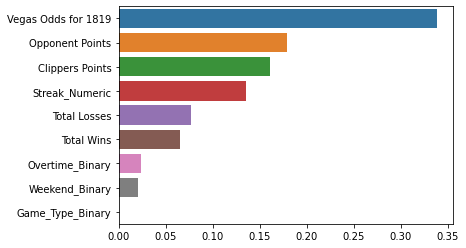

In [177]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.show()

Model -2 This is the model I choose to predict attendance

In [152]:
y=data['Attendance'] #Labels

In [153]:
X=data[[
       'Total Wins', 'Total Losses', 'Weekend_Binary', 'Game_Type_Binary',
        'Vegas Odds for 1819', 'Overtime_Binary', 'Result_Binary',
       'Streak_Numeric', 'Start Time_10:30p', 'Start Time_3:30p',
       'Start Time_5:00p', 'Start Time_9:00p', 'Start Time_9:30p',
       'Opponent_Atlanta Hawks', 'Opponent_Boston Celtics',
       'Opponent_Brooklyn Nets', 'Opponent_Charlotte Hornets',
       'Opponent_Chicago Bulls', 'Opponent_Cleveland Cavaliers',
       'Opponent_Dallas Mavericks', 'Opponent_Denver Nuggets',
       'Opponent_Detroit Pistons', 'Opponent_Golden State Warriors',
       'Opponent_Houston Rockets', 'Opponent_Indiana Pacers',
       'Opponent_Los Angeles Lakers', 'Opponent_Memphis Grizzlies',
       'Opponent_Miami Heat', 'Opponent_Milwaukee Bucks',
       'Opponent_Minnesota Timberwolves', 'Opponent_New Orleans Pelicans',
       'Opponent_New York Knicks', 'Opponent_Oklahoma City Thunder',
       'Opponent_Orlando Magic', 'Opponent_Philadelphia 76ers',
       'Opponent_Phoenix Suns', 'Opponent_Portland Trail Blazers',
       'Opponent_Sacramento Kings', 'Opponent_San Antonio Spurs',
       'Opponent_Toronto Raptors', 'Opponent_Utah Jazz',
       'Opponent_Washington Wizards']]

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
regressor=RandomForestRegressor(n_estimators = 300, random_state = 0)

In [155]:
regressor.fit(X_train,y_train)
y_pred=regressor.predict(X_test)

In [156]:
new=data.drop(['Attendance','Clippers Points', 'Opponent Points'],axis=1)

In [157]:
feature_imp = pd.Series(regressor.feature_importances_,index=new.columns[2:]).sort_values(ascending=False).head(5)

In [158]:
feature_imp

Streak_Numeric                    0.254805
Total Wins                        0.125209
Vegas Odds for 1819               0.121230
Total Losses                      0.094644
Opponent_Oklahoma City Thunder    0.066063
dtype: float64

In [159]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 997.7833333333333
Mean Squared Error: 1653834.998623457
Root Mean Squared Error: 1286.0151626724535


In [160]:
mape = np.mean(np.abs((y_test - y_pred) / np.abs(y_pred)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))

Mean Absolute Percentage Error (MAPE): 12.12
Accuracy: 87.88


<AxesSubplot:>

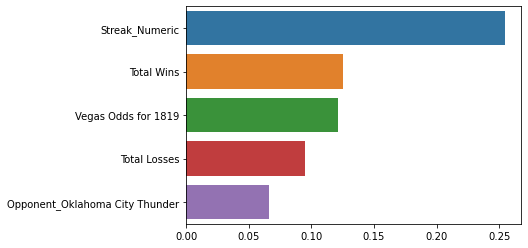

In [161]:
sns.barplot(x=feature_imp, y=feature_imp.index[:5])